In [1]:
import pickle
from io import BytesIO
import numpy as np
from numpy.testing import assert_almost_equal
from onnxruntime import InferenceSession
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.datasets import load_iris
from skl2onnx.common.data_types import guess_numpy_type
from skl2onnx import to_onnx

from sklearn.decomposition import PCA

v=np.random.randn(100,2)
A=np.array([[0.7,0.1],[0.2,0.8]])
X=np.dot(v,A)
pca = PCA(n_components=2)
pca.fit(X)

x_pca=pca.transform(X)
# import linear regression
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x_pca, X)

In [34]:
print(pca.explained_variance_ratio_)
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn

# transform pca_model to onnx
initial_type = [('float_input', FloatTensorType([None, X.shape[1]]))]

onnx_pca_model = convert_sklearn(pca, initial_types=initial_type)

with open("pca_model.onnx", "wb") as f:
    f.write(onnx_pca_model.SerializeToString())

initial_type = [('float_input', FloatTensorType([None, x_pca.shape[1]]))]
onnx_reg_model = convert_sklearn(reg, initial_types=initial_type)

with open("reg_model.onnx", "wb") as f:
    f.write(onnx_reg_model.SerializeToString())



[0.65280936 0.34719064]


In [36]:
from onnx import compose
from onnx.compose import merge_models

reg_model=onnx.load("reg_model.onnx")
pca_model=onnx.load("pca_model.onnx")
print(reg_model)
print(pca_model)


ir_version: 10
producer_name: "skl2onnx"
producer_version: "1.18.0"
domain: "ai.onnx"
model_version: 0
doc_string: ""
graph {
  node {
    input: "float_input"
    output: "variable"
    name: "LinearRegressor"
    op_type: "LinearRegressor"
    attribute {
      name: "coefficients"
      floats: 0.469496459
      floats: 0.882934332
      floats: 0.882934332
      floats: -0.469496459
      type: FLOATS
    }
    attribute {
      name: "intercepts"
      floats: 0.0498833358
      floats: 0.0787142962
      type: FLOATS
    }
    attribute {
      name: "targets"
      i: 2
      type: INT
    }
    domain: "ai.onnx.ml"
  }
  name: "65659717241349ca87c5b9f5f5b2e324"
  input {
    name: "float_input"
    type {
      tensor_type {
        elem_type: 1
        shape {
          dim {
          }
          dim {
            dim_value: 2
          }
        }
      }
    }
  }
  output {
    name: "variable"
    type {
      tensor_type {
        elem_type: 1
        shape {
          d

In [40]:

pca_with_prefix = compose.add_prefix(pca_model, prefix="pca_")
print(pca_with_prefix)

print(reg_model)


ir_version: 10
producer_name: "skl2onnx"
producer_version: "1.18.0"
domain: "ai.onnx"
model_version: 0
doc_string: ""
graph {
  node {
    input: "pca_float_input"
    input: "pca_mean"
    output: "pca_sub_result"
    name: "pca_Sub"
    op_type: "Sub"
    domain: ""
  }
  node {
    input: "pca_sub_result"
    input: "pca_transform_matrix"
    output: "pca_variable"
    name: "pca_MatMul"
    op_type: "MatMul"
    domain: ""
  }
  name: "994bfee2efbd43029223d709f16321a1"
  initializer {
    dims: 2
    dims: 2
    data_type: 1
    float_data: 0.469496459
    float_data: 0.882934332
    float_data: 0.882934332
    float_data: -0.469496459
    name: "pca_transform_matrix"
  }
  initializer {
    dims: 2
    data_type: 1
    float_data: 0.0498833358
    float_data: 0.0787142962
    name: "pca_mean"
  }
  input {
    name: "pca_float_input"
    type {
      tensor_type {
        elem_type: 1
        shape {
          dim {
          }
          dim {
            dim_value: 2
          }


In [41]:
for opset in pca_with_prefix.opset_import:
    if opset.domain != '21':
        opset.version = 21
reg_pca = compose.merge_models(
    pca_with_prefix,
    reg_model,    
    io_map=[('pca_variable', # output pca model
          'float_input')]) 
with open("reg_pca.onnx", "wb") as f:
    f.write(reg_pca.SerializeToString())   

In [42]:
model = onnx.load("reg_pca.onnx")

# Update the opset version
for opset in model.opset_import:
    if opset.domain == "":  # Default domain (ai.onnx)
        opset.version = 21  # Set to a supported version

# Save the updated model
onnx.save(model, "combined_model_v21.onnx")

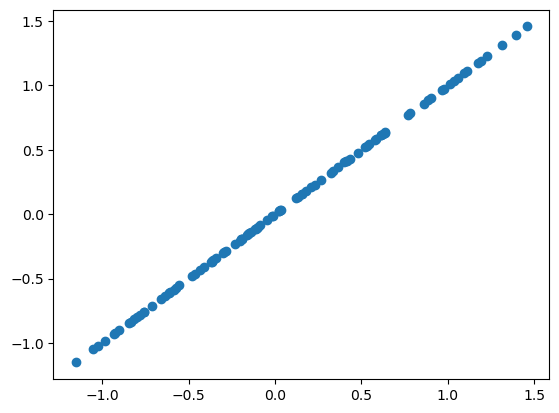

In [44]:
import onnxruntime as ort
import numpy as np

# Load the ONNX model
onnx_model_path = "combined_model_v21.onnx"
session = ort.InferenceSession(onnx_model_path)

# Example data
X_new = np.random.rand(5, 10).astype(np.float32)

# Prepare the input dictionary
input_name = session.get_inputs()[0].name
inputs = {input_name: X.astype(np.float32)}
outputs=session.run(None, inputs)
import matplotlib.pyplot as plt
plt.scatter(X[:,0],outputs[0][:,0]) 

In [46]:
import torch
import torch.nn as nn
#import RELU
import torch.nn.functional as F

# Example: Trained PyTorch model
class SimpleTorchModel(nn.Module):
    def __init__(self):
        super(SimpleTorchModel, self).__init__()
        self.fc = nn.Linear(2, 3)
        self.fc2=nn.Linear(3,2)

    def forward(self, x):
        x = self.fc(x)
        x = F.relu(x)
        x = self.fc2(x)
        return self.fc(x)

model_torch = SimpleTorchModel()
x_torch = torch.randn(1, 2)
torch.onnx.export(model_torch, x_torch, "torch_model.onnx", input_names=['input'], output_names=['output'])

In [31]:
#print(onnx_pca_model)

import onnxruntime as ort
import numpy as np

# Load the ONNX model
onnx_model_path = "combined_model.onnx"
session = ort.InferenceSession(onnx_model_path)

# Example data
#X_new = np.random.rand(5, 10).astype(np.float32)

# Prepare the input dictionary
input_name = session.get_inputs()[0].name
inputs = {input_name: X.astype(np.float32)}

outputs = session.run(None, inputs)
#print(outputs)
plt.scatter(X[:,0],outputs[0][:,0])
y_pred=reg.predict(pca.transform(X))
plt.scatter(X[:,0],y_pred[:,0])

Fail: [ONNXRuntimeError] : 1 : FAIL : Load model from combined_model.onnx failed:/Users/runner/miniforge3/conda-bld/onnxruntime_1735443991643/work/onnxruntime/core/graph/model_load_utils.h:56 void onnxruntime::model_load_utils::ValidateOpsetForDomain(const std::unordered_map<std::string, int> &, const logging::Logger &, bool, const std::string &, int) ONNX Runtime only *guarantees* support for models stamped with official released onnx opset versions. Opset 22 is under development and support for this is limited. The operator schemas and or other functionality may change before next ONNX release and in this case ONNX Runtime will not guarantee backward compatibility. Current official support for domain ai.onnx is till opset 21.


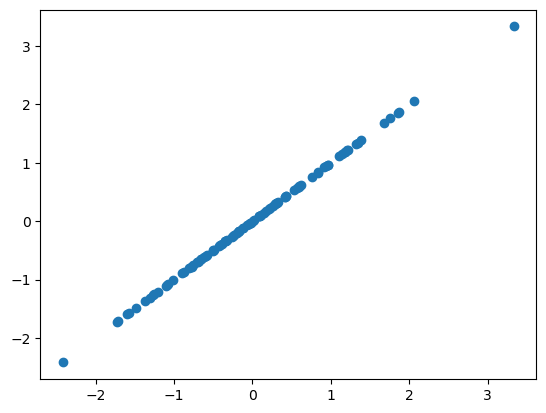

In [18]:

# Run the model
outputs = session.run(None, inputs)
pca_output=pca.transform(X)
import matplotlib.pyplot as plt
plt.scatter(outputs[0][:,0],pca_output[:,0])


In [ ]:
import onnx
from onnx import helper

# Load ONNX models
sklearn_model = onnx.load("sklearn_model.onnx")
torch_model = onnx.load("torch_model.onnx")

# Rename tensors to link models
sklearn_output = sklearn_model.graph.output[0]
torch_input = torch_model.graph.input[0]
torch_input.name = sklearn_output.name  # Link sklearn output to torch input

# Combine nodes and initializers
combined_nodes = sklearn_model.graph.node + torch_model.graph.node
combined_initializers = sklearn_model.graph.initializer + torch_model.graph.initializer

# Define new graph
combined_graph = helper.make_graph(
    combined_nodes,
    "CombinedModel",
    inputs=sklearn_model.graph.input,
    outputs=torch_model.graph.output,
    initializer=combined_initializers,
)

# Create the final model
combined_model = helper.make_model(combined_graph)
onnx.save(combined_model, "combined_model.onnx")
